In [1]:
import spotipy
import collections
import numpy as np
import requests
from bs4 import BeautifulSoup
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="c0c231a63aff41459ff8db2c552830d2",
                                                           client_secret="ca92f9689fd745219c252148f81f4ac2"))

In [3]:
## Use Chartable & BeautifulSoup to get top (podcast) shows on Spotify

genre_data_load = collections.defaultdict(int)

chartable_url = 'https://chartable.com/charts/spotify/us'
page = requests.get(chartable_url, headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'})
page_soup = BeautifulSoup(page.content, 'html.parser')
charts_by_genre = page_soup.find_all('div', class_='podcast mb1')
chart_urls = [chart.find('a')['href'] for chart in charts_by_genre]
chart_urls = chart_urls[:-3] + [chart_urls[-1]]
num_urls = len(chart_urls)

In [4]:
## For each genre, append all of its page urls

next_page_urls = []

def add_next_pages(chart_indices):
    for i in chart_indices:
        temp_chart_url = chart_urls[i]
        while temp_chart_url:
            chart_page = requests.get(temp_chart_url, headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'})
            if (chart_page.status_code != 200):
                return i
            next_page = BeautifulSoup(chart_page.content, 'html.parser').find('span', class_='next')
            if next_page:
                temp_chart_url = 'http://chartable.com' + next_page.find('a')['href']
                next_page_urls.append(temp_chart_url)
            else:
                temp_chart_url = None
    return -1

In [55]:
## DON'T NEED TO RUN THIS CELL -- CHART URLS ALREADY LOADED 

## Need to load data incrementally due to request limit

i = 0
while i != -1:
    i = add_next_pages(range(i, num_urls))
chart_urls += next_page_urls

In [5]:
## Get show titles using chart urls from Chartable

genres_to_shows = collections.defaultdict(list)

def collect_shows(chart_indices):
    for i in chart_indices:
        chart_url = chart_urls[i]
        chart_page = requests.get(chart_url, headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'})
        if (chart_page.status_code != 200):
            return i

        show_soup = BeautifulSoup(chart_page.content, 'html.parser')
        all_shows = show_soup.find_all('tr', class_='striped--near-white')

        key = ' '.join(((chart_url.split('/')[-1]).split('-'))[4:])
        genre_data_load[key] = len(all_shows)

        for show in all_shows:
            show_name = show.find('a', class_='link blue')
            show_rank = show.find('div', class_='b header-font f2 tc')
            if not show_name:
                show_name = show.find('div', class_='title f4')
            genre = key.split('?')[0]
            genres_to_shows[genre].append({"show_name": show_name.text, "rank": show_rank.text})
    return -1

In [57]:
## DON'T NEED TO RUN THIS CELL -- SHOW NAMES ALREADY LOADED ##

## Need to load data incrementally due to request limit

i = 0
while i != -1:
    i = collect_shows(range(i, num_urls))
print(len(genres_to_shows))

20


In [58]:
np.save('chartable_genres_to_shows.npy', genres_to_shows) 

In [6]:
# GET ALL SHOWS

shows = dict()
genres_to_shows = np.load('chartable_genres_to_shows.npy', allow_pickle='TRUE').item()

for genre, show_data in genres_to_shows.items():
    for show in show_data:
        try: 
            show_name, rank = show['show_name'], show['rank']
            results = sp.search(q=show_name, type='show', market='US')
            show = results['shows']['items'][0]
            new_show = {
                "id": show['id'],
                "name": show['name'],
                "description": show['description'],
                "genre": genre,
                "languages": show['languages'],
                "publisher": show['publisher'],
                "show_rank": rank
            }
            shows[new_show['id']] = new_show
        except:
            continue

np.save('shows.npy', shows) 

In [4]:
# GET ALL EPISODES

episodes = dict()
shows = np.load('shows.npy', allow_pickle='TRUE').item()

for show_id in shows.keys():
    try: 
        results = sp.show_episodes(show_id, limit=50, offset=0, market='US')
        episode_items = results['items']
        for episode in episode_items:
            new_episode = {
                "id": episode['id'],
                "show_id": show_id,
                "name": episode['name'],
                "description": episode['description'],
                "duration_ms": episode['duration_ms'],
                "genre": shows[show_id]['genre'],
                "languages": episode['languages'],
                "publisher": shows[show_id]['publisher'],
                "release_date": episode['release_date'],
                "release_date_precision": episode['release_date_precision'],
                "show_rank": shows[show_id]['show_rank']
            }
            episodes[episode['id']] = new_episode
    except:
        continue

np.save('episodes.npy', episodes) 

In [6]:
print(len(shows))
print(len(episodes))

679
28761


In [42]:
# shows = np.load('shows.npy',allow_pickle='TRUE').item()
# episodes = np.load('episodes.npy',allow_pickle='TRUE').item()

#### Shows Table

In [58]:
shows_df = pd.DataFrame(list(shows.values()))
print("number of shows: {}".format(shows_df.shape[0]))
shows_df.head()

number of shows: 719


,id,name,description,languages
0,2vNdjiBQa7Gy4SmLyhULlR,Entre Hermanas con Alejandra Espinoza y Damari...,"Alejandra Espinoza, la famosa reina de ...",[es]
1,4KDCRj2TjqVXzR5iy1Izda,The Bitch Bible,A podcast that dares to say what many are thin...,[en]
2,0mWUJuONiilW5JSBBFZ0s7,The What Bitcoin Did Podcast,"Bitcoin & Crypto Trading, Strategy, Business a...",[en]
3,5okWIPi7GOb4iaZQlVthi5,K-Pop Daebak w/ Eric Nam,It's hard to keep up with all the new K-pop re...,[en]
4,1g056e2x0Y9AwW6CQF3qA5,Mythology,Myths endure for a reason. This episodic audio...,[en]


In [59]:
episodes_df = pd.DataFrame(list(episodes.values()))
print("number of episodes: {}".format(episodes_df.shape[0]))
episodes_df.head()

number of episodes: 29240


,id,show_id,name,description,release_date,duration_ms,languages
0,4u7SBsPFOPFwwCohVe8rEA,2vNdjiBQa7Gy4SmLyhULlR,Los errores que destruyen una relación,Todos queremos una relación de pareja...,2021-04-08,2027860,[es]
1,7GvPOtrdromUiTKQWaTgUX,2vNdjiBQa7Gy4SmLyhULlR,Por qué nos cuesta tanto hablar de sexo,"Una conversación ""Entre Hermanas"" sob...",2021-04-01,1812349,[es]
2,2k2yZxofWpcWPUcCWAlRyf,2vNdjiBQa7Gy4SmLyhULlR,Te fueron infiel...¿y ahora qué?,"Una conversación ""Entre Hermanas"" con...",2021-03-25,2025221,[es]
3,2WlMmi51TVK1zVsBDZkbAL,2vNdjiBQa7Gy4SmLyhULlR,Los secretos de Ale y Damaris para tener buena...,Toma nota porque Alejandra y Damaris ...,2021-03-18,1985985,[es]
4,2F1CclIr6N6WATYE8u1LT4,2vNdjiBQa7Gy4SmLyhULlR,Cómo lograr todo lo que te propones,Damaris enfrentó a Alejandra cuando l...,2021-03-11,2485864,[es]


#### Length of Show and Episode Description Analysis


In [45]:
print("average length of show description: {} words".format(np.mean(shows_df['description'].apply(lambda x: len(x)))))
print("average length of episode description: {} words".format(np.mean(episodes_df['description'].apply(lambda x: len(x)))))

average length of show description: 363.34075104311546 words
average length of episode description: 752.300512995896 words


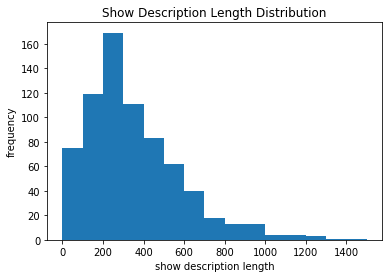

In [46]:
plt.hist(shows_df['description'].apply(lambda x: len(x)), range=(0,1500), bins=15)
plt.xlabel("show description length")
plt.ylabel("frequency")
plt.title('Show Description Length Distribution')
plt.show()

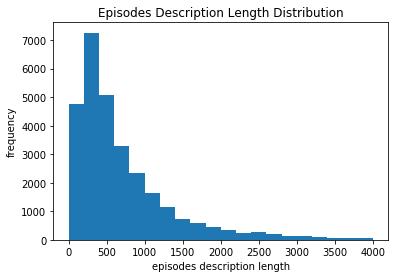

In [47]:
plt.hist(episodes_df['description'].apply(lambda x: len(x)),range=(0,4000),bins=20)
plt.xlabel("episodes description length")
plt.ylabel("frequency")
plt.title('Episodes Description Length Distribution')
plt.show()

#### Episode and Show Description Character Usage Analysis 

In [48]:
import re

show_description_tokens = []
for description in shows_df['description']:
    show_description_tokens+=(re.sub(r'[^a-zA-Z ]+', '', description).split())
show_description_tf = collections.Counter(show_description_tokens)

episode_description_tokens = []
for description in episodes_df['description']:
    episode_description_tokens+=(re.sub(r'[^a-zA-Z ]+', '', description).split())
episode_description_tf = collections.Counter(episode_description_tokens)

In [49]:
print("Top 10 most frequent words and their term frequencies in show description: \n")
for word, score in sorted(show_description_tf.items(),key = lambda x: x[1],reverse=True)[:10]:
    print("'{}', term frequency: {}".format(word,score))

print("\n")
print("Top 10 least frequent words and their term frequencies in show description: \n")
for word, score in sorted(show_description_tf.items(),key = lambda x: x[1])[:10]:
    print("'{}', term frequency: {}".format(word,score))





Top 10 most frequent words and their term frequencies in show description: 

'and', term frequency: 1872
'the', term frequency: 1691
'of', term frequency: 972
'to', term frequency: 945
'a', term frequency: 792
'in', term frequency: 491
'you', term frequency: 450
'is', term frequency: 406
'with', term frequency: 361
'for', term frequency: 326


Top 10 least frequent words and their term frequencies in show description: 

'Alejandra', term frequency: 1
'Espinoza', term frequency: 1
'famosa', term frequency: 1
'hermana', term frequency: 1
'Damaris', term frequency: 1
'Jimenez', term frequency: 1
'quien', term frequency: 1
'especializada', term frequency: 1
'desarrollo', term frequency: 1
'mujeres', term frequency: 1


In [50]:
print("\n")
print("Top 10 most frequent words and their term frequencies in episode description: \n")
for word, score in sorted(episode_description_tf.items(),key = lambda x: x[1],reverse=True)[:10]:
    print("'{}', term frequency: {}".format(word,score)) 

print("\n")
print("Top 10 least frequent words and their term frequencies in episode description: \n")
for word, score in sorted(episode_description_tf.items(),key = lambda x: x[1])[:10]:
    print("'{}', term frequency: {}".format(word,score)) 



Top 10 most frequent words and their term frequencies in episode description: 

'the', term frequency: 115868
'and', term frequency: 99356
'to', term frequency: 81093
'of', term frequency: 66928
'a', term frequency: 58276
'in', term frequency: 36469
'for', term frequency: 34049
'on', term frequency: 29830
'is', term frequency: 27957
'you', term frequency: 25104


Top 10 least frequent words and their term frequencies in episode description: 

'maravillosa', term frequency: 1
'caros', term frequency: 1
'honesta', term frequency: 1
'tranquilidad', term frequency: 1
'claros', term frequency: 1
'Toma', term frequency: 1
'saludables', term frequency: 1
'sorprender', term frequency: 1
'gimnasio', term frequency: 1
'propuso', term frequency: 1


#### Episode Lenght Analysis

In [51]:
print("Mean duration of episodes: {:.2f} milliseconds".format(episodes_df['duration_ms'].mean()))
print("Mean duration of episodes: {:.2f} seconds".format(episodes_df['duration_ms'].mean()/1000))
print("Mean duration of episodes: {:.2f} minutes".format(episodes_df['duration_ms'].mean()/60000))

Mean duration of episodes: 3230245.66 milliseconds
Mean duration of episodes: 3230.25 seconds
Mean duration of episodes: 53.84 minutes


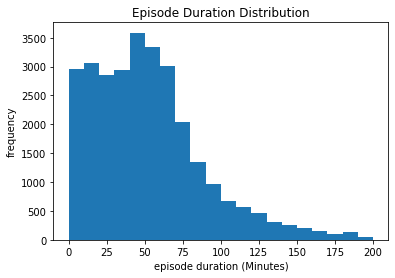

In [52]:
plt.hist(episodes_df['duration_ms']/60000,range=(0,200),bins=20)
plt.xlabel("episode duration (Minutes)")
plt.ylabel("frequency")
plt.title("Episode Duration Distribution")
plt.show()

#### Show Language Distribution 

In [53]:
print("Most used languages in the shows")
display(shows_df['languages'].apply(lambda x: x[0]).value_counts())

Most used languages in the shows


en       630
en-US     70
es        14
aa         3
en-GB      1
ja         1
Name: languages, dtype: int64

#### Shows and Episodes Analysis 

In [54]:
print("10 shows with the most episodes: \n")
show_episode_df = episodes_df.merge(shows_df, left_on="show_id",right_on="id")
for i,show in enumerate(show_episode_df.groupby('name_y').count()['id_x'].sort_values(ascending=False)[0:10].index):
    print("{}) {}".format(i+1, show)) 

10 shows with the most episodes: 

1)  The No Good Podcast 
2) Snoozecast
3) Something Was Wrong
4) Something to Wrestle with Bruce Prichard
5) Song Exploder
6) Southern Fried True Crime
7) Spiritual Shit 
8) Spittin Chiclets
9) Spooky Boo's Creepypasta, True Scary Stories, Paranormal, and True Crime Podcast
10) Star Wars Theory
